In [4]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import gpjax as gpx
import jax.numpy as jnp
import kohgpjax as kgx
import jax
from kohgpjax.parameters import ModelParameters

from models.sin_a import Model, get_ModelParameterPriorDict
import dataloader

from plotting import (
    plot_f_eta,
    plot_f_delta,
    plot_f_zeta,
    plot_pairwise_samples,
    plot_posterior_chains_with_priors,
    plot_sim_sample,
    # plot_time_vs_sim_output,
)

from data.true_funcs import (
    discrepancy,
    eta,
    TrueParams,
    zeta,
)


TP = TrueParams()
num_calib_params=1

Load observations and simulation outputs

In [5]:
kohdataset, tminmax, ycmean = dataloader.load(
    sim_file_path_csv=f"data/sim-a.csv",
    obs_file_path_csv=f"data/obs-a.csv",
    num_calib_params=num_calib_params,
)

Load posterior samples

In [6]:
chains = az.from_netcdf("chains/sin-a-W80-N50-Nsim1000.nc")
print(az.summary(chains))

# 2.2 Extract the transformed parameters
posterior_means = chains.posterior.mean()
print(f"Posterior means: {posterior_means}")


                            mean      sd   hdi_3%  ...  ess_bulk  ess_tail  r_hat
delta_lengthscale_x_0     14.886   5.714    5.914  ...      47.0      71.0   1.00
delta_precision           25.305  15.890    6.253  ...      72.0      50.0   1.02
epsilon_precision        405.296  11.907  384.158  ...      48.0      59.0   1.02
eta_lengthscale_theta_0    4.674   0.648    3.587  ...      58.0      78.0   1.05
eta_lengthscale_x_0        0.873   0.051    0.773  ...      41.0      58.0   1.04
eta_precision              0.595   0.246    0.198  ...      16.0      25.0   1.10
theta_0                    0.399   0.006    0.388  ...     111.0      77.0   1.12

[7 rows x 9 columns]
Posterior means: <xarray.Dataset> Size: 56B
Dimensions:                  ()
Data variables:
    delta_lengthscale_x_0    float64 8B 14.89
    delta_precision          float64 8B 25.31
    epsilon_precision        float64 8B 405.3
    eta_lengthscale_theta_0  float64 8B 4.674
    eta_lengthscale_x_0      float64 8B 0.8727

In [7]:
x0_pred = np.linspace(0, 4, 1000)
x1_pred = np.zeros_like(x0_pred)
xpred = np.vstack((x0_pred, x1_pred)).T
print(xpred.shape)

# 3.2 Get the theta vector and tile for array
theta_vec = TP.get_theta().squeeze()  # TODO: Should this be a jnp.array?
for i in range(num_calib_params):
    theta_vec[i] = posterior_means[f"theta_{i}"].values
theta_arr = jnp.tile(theta_vec, (xpred.shape[0], 1))
print(f"theta_vec: {theta_vec}")
print(theta_arr.shape)

# 3.3 Full x_test array
x_test = np.hstack((xpred, theta_arr))
print(x_test.shape)

# 3.4 extract variables used for GP
x_test_GP = x_test[:, [0] + list(range(2, 2 + num_calib_params))]
print(x_test_GP.shape)

# 3.5 Generate the full dataset
dataset = kohdataset.get_dataset(theta_vec[:num_calib_params].reshape(1, -1))
print(dataset)

(1000, 2)
theta_vec: [ 0.39895676 -3.14        1.          1.          0.5       ]
(1000, 5)
(1000, 7)
(1000, 2)
Dataset(Number of observations: 3100 - Input dimension: 2)


In [8]:
prior_dict = get_ModelParameterPriorDict(tminmax)
model_parameters = ModelParameters(prior_dict=prior_dict)

# 4.3 Create the model instance
model = Model(
    model_parameters=model_parameters,
    kohdataset=kohdataset,
)

# 4.4 Get the parameters into the correct format
prior_leaves, prior_tree = jax.tree.flatten(prior_dict)
# cannot assume jax tree and arviz/xarray ordering is the same
GP_params_flat = {p.name: posterior_means[p.name].values for p in prior_leaves}
thetas = jnp.array([GP_params_flat[f"theta_{i}"] for i in range(num_calib_params)])
GP_params = jax.tree.unflatten(prior_tree, GP_params_flat.values())

# 4.5 Build the GP posterior
GP_posterior = model.GP_posterior(GP_params)
# print(f"GP posterior: {GP_posterior}")

Creating ModelParameterPriorDict for sin-a model...
A0: -0.02347600873936904, B0: 1.0205447979783209


In [ ]:
# 5 Generating the predictions
# 5.1 Predict the eta, zeta, and obs values
print("Generating predictions...")
eta_pred = GP_posterior.predict_eta(x_test_GP, dataset)
zeta_pred = GP_posterior.predict_zeta(x_test_GP, dataset)
obs_pred = GP_posterior.predict_obs(x_test_GP, dataset)

Generating predictions...


In [11]:
eta_pred_m = eta_pred.mean
eta_pred_cov = eta_pred.covariance_matrix

zeta_pred_m = zeta_pred.mean
zeta_pred_cov = zeta_pred.covariance_matrix

obs_pred_m = obs_pred.mean
obs_pred_cov = obs_pred.covariance_matrix

# 5.2 Model discrepancy
delta_gp_m = zeta_pred_m - eta_pred_m
delta_gp_cov = zeta_pred_cov + eta_pred_cov

Compare $f_\eta$, $f_\zeta$ and $f_{\zeta+\epsilon}$

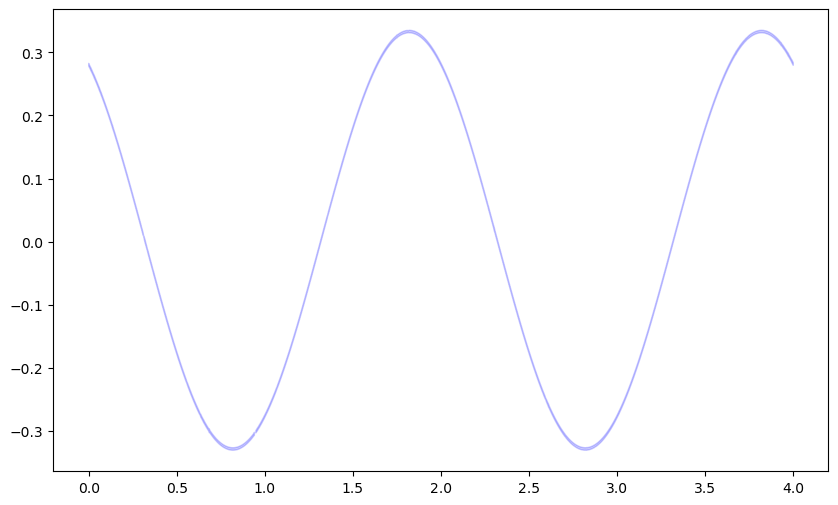

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# ax.plot(
#     x_test_GP[:, 0],
#     eta_pred_m,
#     label="GP posterior mean of $f_\\eta$",
#     color="blue",
# )
ax.fill_between(
    x_test_GP[:, 0],
    eta_pred_m - 2 * jnp.sqrt(jnp.diag(eta_pred_cov)),
    eta_pred_m + 2 * jnp.sqrt(jnp.diag(eta_pred_cov)),
    alpha=0.2,
    color="blue",
)
# ax.plot(
#     x_test_GP[:, 0],
#     zeta_pred_m,
#     label="GP posterior mean of $f_\\zeta$",
#     color="orange",
# )
# ax.fill_between(
#     x_test_GP[:, 0],
#     zeta_pred_m - 2 * jnp.sqrt(jnp.diag(zeta_pred_cov)),
#     zeta_pred_m + 2 * jnp.sqrt(jnp.diag(zeta_pred_cov)),
#     alpha=0.2,
#     color="orange",
# )
# ax.plot(
#     x_test_GP[:, 0],
#     obs_pred_m,
#     label="GP posterior mean of $f_{\\zeta + \\epsilon}$",
#     color="green",
#     linestyle="--",
# )
# ax.fill_between(
#     x_test_GP[:, 0],
#     obs_pred_m - 2 * jnp.sqrt(jnp.diag(obs_pred_cov)),
#     obs_pred_m + 2 * jnp.sqrt(jnp.diag(obs_pred_cov)),
#     alpha=0.2,
#     color="green",
# )
plt.show()